## Dataset importation
At first, we import the dataset in csv format and perform an essential exploration of its features.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
print(data.columns)
data.head()

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Pre-processing of the data

Since some labels are missing we consider for the training dataset the players with both ratings. Note that there are no players with a single rating missing.

In [3]:
missing_rater_data=data[data.rater2.isnull() & data.rater1.isnull()]
rater_data=data[data.rater2.notnull() & data.rater1.notnull()]

In [4]:
rater_data.shape

(124621, 28)

In [5]:
missing_rater_data.shape

(21407, 28)

In [6]:
data.shape

(146028, 28)

## Data analysis
### Preprocessing

- Delete the column photoID
- Delete all the rows corresponding to a referee with less than 22 entry (impossible - problem in the dataset)
- Remove less significant referee entry (with nIAT and nExp too low) [preprocess_2]

In [7]:
def preprocess_1(database,remove_bad_referee=True,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    del train['photoID']
    
    train_group=train.groupby(train.refNum)
    
    if remove_bad_referee:
        for i,group in train_group:
            if group.shape[0]<22:
                train=train.drop(train_group.get_group(i).index)
            if i%500==0:
                print(i)
    
   
    return train

In [8]:
train_after_prep_1=preprocess_1(rater_data,remove_bad_referee=True)

500
1000
1500
2000
2500
3000


In [9]:
def preprocess_2(database,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    train_group=database.groupby(train.refNum)

    for i,group in train_group:
        if group.nIAT.iloc[0]<nIAT_threshold or group.nExp.iloc[0]<nExp_threshold:
            train=train.drop(train_group.get_group(i).index)
        if i%200==0:
            print(i)
    return train

In [10]:
train_after_prep_2=preprocess_2(train_after_prep_1)

1600
2400
3000


In [11]:
rater_data.shape

(124621, 28)

In [12]:
train_after_prep_1.shape

(112484, 27)

In [13]:
train_after_prep_2.shape

(111533, 27)

In [14]:
train_after_prep_2['IAT_yellow']=train_after_prep_2.yellowCards*train_after_prep_2.meanIAT
train_after_prep_2['IAT_red']=train_after_prep_2.redCards*train_after_prep_2.meanIAT
train_after_prep_2['Exp_yellow']=train_after_prep_2.yellowCards*train_after_prep_2.meanExp
train_after_prep_2['Exp_red']=train_after_prep_2.redCards*train_after_prep_2.meanExp

In [46]:
train_after_prep_2.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,IAT_yellow,IAT_red,Exp_yellow,Exp_red
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
10,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.325185,0.0,0.538462,0.0
11,ashkan-dejagah,Ashkan Dejagah,Fulham FC,England,05.07.1986,181.0,74.0,Left Winger,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
12,benedikt-hoewedes,Benedikt Höwedes,FC Schalke 04,Germany,29.02.1988,187.0,80.0,Center Back,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
13,chris-baird,Chris Baird,Fulham FC,England,25.02.1982,186.0,77.0,Defensive Midfielder,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0
14,chris-brunt,Chris Brunt,West Bromwich Albion,England,14.12.1984,185.0,74.0,NaN,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000000,0.0,0.000000,0.0


In [16]:
(train_after_prep_2.nExp[train_after_prep_2.nExp<100]).value_counts()

95.0    77
69.0    37
76.0    28
Name: nExp, dtype: int64

In [17]:
min(train_after_prep_2.nExp)

69.0

## Random forest with referee information

Operations done:

- Keep only the wanted features
- Fill NaN with median of the columns or with 'nan' if categorical variable
- Keep only the year of birth (not the date)
- Add dummy variables for the categorical variables
- Keep one entry for player
- Extract y as mean of the rater1 and rater2

In [18]:
train=train_after_prep_2[['playerShort','leagueCountry','birthday','height','weight','position','rater1','rater2','IAT_yellow','IAT_red','Exp_yellow','Exp_red']]

In [19]:
train=train.fillna(train.median())

In [20]:
train.position=train.position.fillna('nan')

In [21]:
train.leagueCountry=train.leagueCountry.fillna('nan')

In [22]:
train.birthday=train.birthday.apply(lambda x: int(x.split('.')[2]))

In [23]:
a=pd.get_dummies(train[['position','leagueCountry']])

In [24]:
train=pd.concat([train,a],axis=1)

In [25]:
del train['leagueCountry']
del train['position']

In [26]:
train=train.groupby('playerShort').mean()

In [27]:
train.head()

,birthday,height,weight,rater1,rater2,IAT_yellow,IAT_red,Exp_yellow,Exp_red,position_Attacking Midfielder,...,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979,182.0,71.0,0.25,0.00,0.042801,0.000000,0.054873,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-hunt,1986,183.0,73.0,0.00,0.25,0.142176,0.003581,0.162350,0.003574,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-lennon,1987,165.0,63.0,0.25,0.25,0.036889,0.000000,0.044686,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-ramsey,1990,178.0,76.0,0.00,0.00,0.108983,0.003486,0.138661,0.003501,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,1990,180.0,73.0,0.25,0.25,0.076499,0.019125,0.076823,0.019206,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
train.shape

(1584, 26)

In [29]:
y_ref=(train['rater1']+train['rater2'])/2
y_ref.head()

playerShort
aaron-hughes              0.125
aaron-hunt                0.125
aaron-lennon              0.250
aaron-ramsey              0.000
abdelhamid-el-kaoutari    0.250
dtype: float64

In [31]:
#del train_ref['playerShort']
del train['rater1']
del train['rater2']

In [68]:
train.head()

,birthday,height,weight,IAT_yellow,IAT_red,Exp_yellow,Exp_red,position_Attacking Midfielder,position_Center Back,position_Center Forward,...,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979,182.0,71.0,0.042801,0.000000,0.054873,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-hunt,1986,183.0,73.0,0.142176,0.003581,0.162350,0.003574,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-lennon,1987,165.0,63.0,0.036889,0.000000,0.044686,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-ramsey,1990,178.0,76.0,0.108983,0.003486,0.138661,0.003501,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,1990,180.0,73.0,0.076499,0.019125,0.076823,0.019206,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Question 2: clustering
Choices to be done:
* Choice of the algorithm: KMeans (with this one, we can choose the final number of clusters we want) or DBSCAN (we have to impose a metric, but it is not suited for our goal since we cannot impose the number of clusters we want to find).
* Choice of 'init' paratmeter of KMeans
* Choice of the features to iterately remove, and in which order (in particular, with or without the rater's means)
* Sample size of the silhouette score

TODO: 
* Cross-validation (K-fold)
* Last test set

In [193]:
train['skinColor'] = y_ref

In [194]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from time import time
X_train, X_test, y_train, y_test = train_test_split(train, y_ref, test_size=0.4, random_state=4)

In [195]:
labels = 1*(y_train>0.5)

In [210]:
def estimate_data(estimator, metric, name, data):
    t0 = time()
    estimator.fit(data)
    silh_score = metrics.silhouette_score(data, estimator.labels_, metric=metric)
    print('% 9s   %.2fs    %.3f'
         % (name, (time() - t0), silh_score))
    return silh_score

In [201]:
metric_silhouette = 'euclidean'
kmpp = KMeans(init='k-means++', n_clusters=2)
km_rand = KMeans(init='random', n_clusters=2)

estimate_data(kmpp,metric_silhouette,'k-means++ euclidean   ',X_train)
estimate_data(km_rand,metric_silhouette,'k-means rand euclidean',X_train)

k-means++ euclidean      0.07s    0.378
k-means rand euclidean   0.03s    0.379


We first collect the column labels and then class them by increasing order of importance, in order to be able to take them out of the analysis one by one.

In [202]:
col_idx = X_train.columns
col_idx

Index(['birthday', 'height', 'weight', 'IAT_yellow', 'IAT_red', 'Exp_yellow',
       'Exp_red', 'position_Attacking Midfielder', 'position_Center Back',
       'position_Center Forward', 'position_Center Midfielder',
       'position_Defensive Midfielder', 'position_Goalkeeper',
       'position_Left Fullback', 'position_Left Midfielder',
       'position_Left Winger', 'position_Right Fullback',
       'position_Right Midfielder', 'position_Right Winger', 'position_nan',
       'leagueCountry_England', 'leagueCountry_France',
       'leagueCountry_Germany', 'leagueCountry_Spain', 'skinColor'],
      dtype='object')

In [203]:
cols = ['birthday', 'height', 'weight', 'position_Attacking Midfielder', 
        'position_Center Back', 'position_nan', 'position_Center Forward',
        'position_Center Midfielder', 'position_Defensive Midfielder', 
        'position_Goalkeeper', 'position_Left Fullback', 'position_Left Midfielder',
        'position_Left Winger', 'position_Right Fullback',
        'position_Right Midfielder', 'position_Right Winger', 
        'leagueCountry_Germany', 'leagueCountry_Spain',
        'leagueCountry_England', 'leagueCountry_France',
        'IAT_yellow', 'IAT_red', 'Exp_yellow', 'Exp_red', 'skinColor']

In [211]:
scores = []
for i in range(1,len(cols)):
    scores.append(
        estimate_data(kmpp,metric_silhouette,'k-means++ euclidean   ',X_train[cols[i:]]))

k-means++ euclidean      0.25s    0.458
k-means++ euclidean      0.20s    0.516
k-means++ euclidean      0.20s    0.171
k-means++ euclidean      0.21s    0.179
k-means++ euclidean      0.21s    0.197
k-means++ euclidean      0.22s    0.211
k-means++ euclidean      0.20s    0.232
k-means++ euclidean      0.20s    0.240
k-means++ euclidean      0.20s    0.267
k-means++ euclidean      0.19s    0.297
k-means++ euclidean      0.32s    0.320
k-means++ euclidean      0.27s    0.339
k-means++ euclidean      0.23s    0.350
k-means++ euclidean      0.23s    0.377
k-means++ euclidean      0.25s    0.396
k-means++ euclidean      0.23s    0.409
k-means++ euclidean      0.20s    0.419
k-means++ euclidean      0.21s    0.507
k-means++ euclidean      0.19s    0.635
k-means++ euclidean      0.21s    0.539
k-means++ euclidean      0.20s    0.573
k-means++ euclidean      0.21s    0.573
k-means++ euclidean      0.19s    0.706
k-means++ euclidean      0.20s    0.711


In [213]:
import matplotlib.pyplot as plt
%matplotlib inline

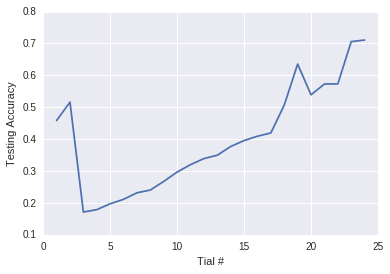

In [214]:
plt.plot(range(1,len(cols)), scores)
plt.xlabel('Tial #')
plt.ylabel('Testing Accuracy')